In [394]:
import numpy as np
from scipy.stats import gamma
import torch
from adaptnn.adaptive_layers import AdaptiveLinear
from adaptnn.adaptive_layers import FixedAdaptiveLinear
import matplotlib.pyplot as plt
from scipy.special import expit

torch.set_default_device('cuda:0')

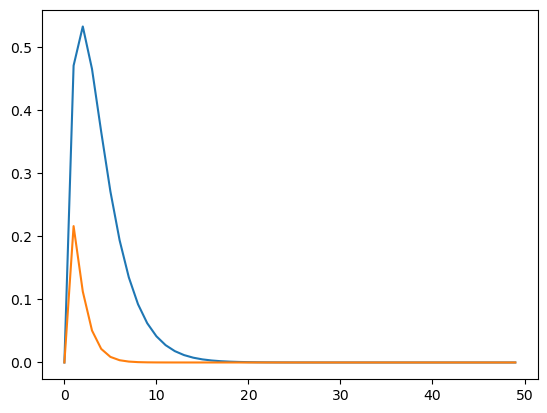

In [395]:
P  = 50
xx = np.arange(0,P)
filter_0 = gamma.pdf(xx, 1.9, scale=2)
filter_1 = gamma.pdf(xx, 1.5, scale=1)
filter_0 = filter_0/np.linalg.norm(filter_0)
filter_1 = filter_1/np.linalg.norm(filter_1)*0.25

b_0 = 1;
b_1 = 0.25;

plt.plot(xx,filter_0)
plt.plot(xx,filter_1)

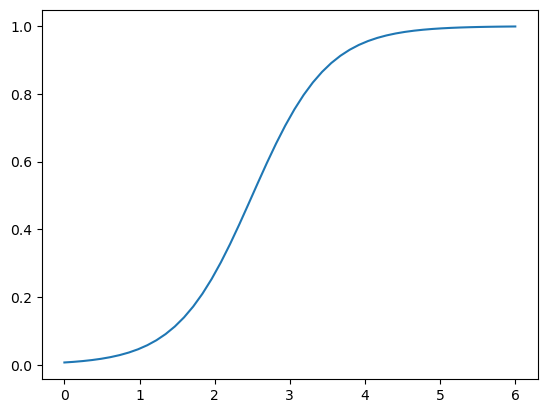

In [396]:
def contrast_function(x):
    return expit(2*(x - 2.5))

cs = np.linspace(0,6,50)
plt.plot(cs, contrast_function(cs))

True MSE = 0.04000000000000001


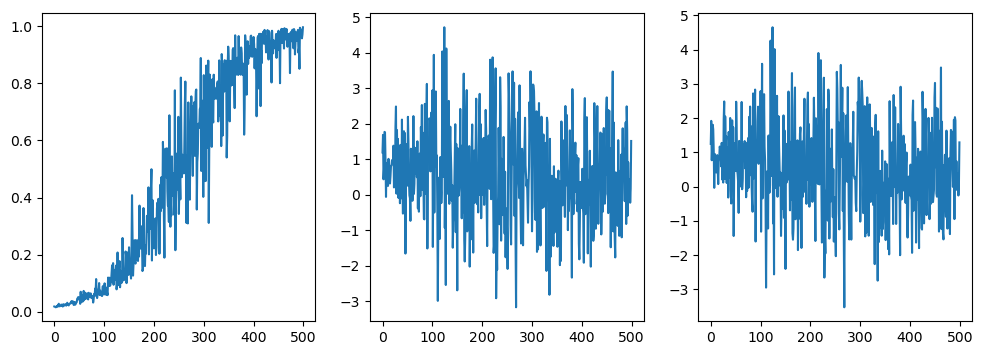

In [424]:
N = 500
true_contast = np.linspace(0.5,4.5,N)
X = np.random.randn(N,P) * true_contast[:,np.newaxis]

sig= 0.2
noise = np.random.randn(N)*sig

X_cs = np.std(X,axis=1, keepdims=True)

W = contrast_function(X_cs)

effective_filters = (1-W) @ filter_0[np.newaxis,:] + (W) @ filter_1[np.newaxis,:]

effective_baseline = b_0*(1-W) + W*b_1

X_filt = np.sum(effective_filters*X,axis=1,keepdims=True) + effective_baseline

Y = X_filt.ravel() + noise
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(W)
plt.subplot(1,3,2)
plt.plot(Y)
plt.subplot(1,3,3)
plt.plot(X_filt)

Xa = X
Xs = X

Xs = X[:,:25]
Xa = np.hstack([X, X**2])


# Xa = np.hstack([X.mean(axis=1,keepdims=True), (X**2).mean(axis=1,keepdims=True)])
print(f"True MSE = {sig**2}")

In [439]:


M = np.zeros((50,9))
for jj,ii in enumerate(range(0,45,5)):
    M[ii:(ii+10),jj] = 1
X2 = X**2
Xa = np.hstack([X@M, X2@M])

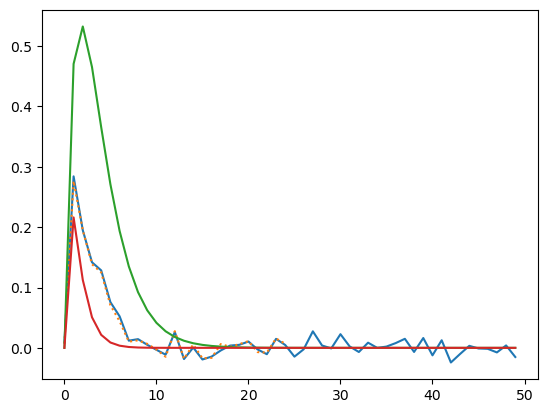

In [440]:
beta_est, *_ = np.linalg.lstsq(np.hstack([X,np.ones((N,1))]) ,Y, rcond=None)
b_est = beta_est[-1]
filt_est = beta_est[:-1]

beta_est2, *_ = np.linalg.lstsq(np.hstack([Xs,np.ones((N,1))]) ,Y, rcond=None)
b_est2 = beta_est2[-1]
filt_est2 = beta_est2[:-1]

plt.plot(filt_est)
plt.plot(filt_est2,':')
plt.plot(filter_0)
plt.plot(filter_1)

In [441]:

X_t  = torch.tensor(Xs/np.std(Xs,axis=0,keepdims=True),dtype=torch.float32)
Xa_t = torch.tensor(Xa/np.std(Xa,axis=0,keepdims=True),dtype=torch.float32)
Y_t = torch.tensor(Y,dtype=torch.float32).reshape(N,1)
P_mod = [2]
print(X_t.device)

def train_model(epochs=5000):
    model = AdaptiveLinear(Xs.shape[1], 1,
                           Xa.shape[1], P_mod)
    criterion=torch.nn.MSELoss()
    learning_rate=0.1
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=4000)
    model.train()
    for epoch in range(epochs):
        
        #convert numpy array to torch Variable
        optimizer.zero_grad()
        
        #Forward to get outputs
        outputs=model(X_t,Xa_t)
        
        #calculate loss
        loss=criterion(outputs, Y_t)
        
        #getting gradients wrt parameters
        loss.backward()
        
        #updating parameters
        optimizer.step()
        scheduler.step()
        
        if((epoch+1) % 500 == 0):
            print(f"epoch {epoch+1}, loss {loss.data}, step size {optimizer.param_groups[0]['lr']}")
    return model
def train_model2(epochs = 100, lr = 1, max_iter=20):
    model = AdaptiveLinear(Xs.shape[1], 1,
                       Xa.shape[1], P_mod)
    criterion=torch.nn.MSELoss()

    lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=max_iter, lr=lr)
    model.train()
    def closure():
        if torch.is_grad_enabled():
            lbfgs.zero_grad()
        output = model(X_t,Xa_t)
        loss = criterion(output, Y_t)
        if loss.requires_grad:
            loss.backward()
        return loss

    for epoch in range(epochs):
        lbfgs.step(closure)
        # output = model(X_t,Xa_t)
        loss = closure()
        if((epoch+1) % 10 == 0):
            print(f"epoch {epoch+1}, loss {loss.data}, step size {lbfgs.param_groups[0]['lr']}")
    return model
model = AdaptiveLinear(Xs.shape[1], 1,
                       Xa.shape[1], P_mod)

cuda:0


In [442]:
model = train_model()

epoch 500, loss 0.03474181517958641, step size 0.08875000000000027
epoch 1000, loss 0.03307066485285759, step size 0.07750000000000051
epoch 1500, loss 0.032279208302497864, step size 0.06625000000000096
epoch 2000, loss 0.03191659599542618, step size 0.05500000000000089
epoch 2500, loss 0.03174138814210892, step size 0.04375000000000055
epoch 3000, loss 0.03163241967558861, step size 0.03249999999999986
epoch 3500, loss 0.03156472370028496, step size 0.02124999999999992
epoch 4000, loss 0.03152836859226227, step size 0.009999999999999959
epoch 4500, loss 0.03150620311498642, step size 0.009999999999999959
epoch 5000, loss 0.031484782695770264, step size 0.009999999999999959


In [415]:
model = train_model2(lr=1,epochs=30)

epoch 10, loss 0.04041420295834541, step size 1
epoch 20, loss 0.040412720292806625, step size 1
epoch 30, loss 0.040412720292806625, step size 1


Text(0, 0.5, 'true modulator\n(standard deviation of sample -> expit)')

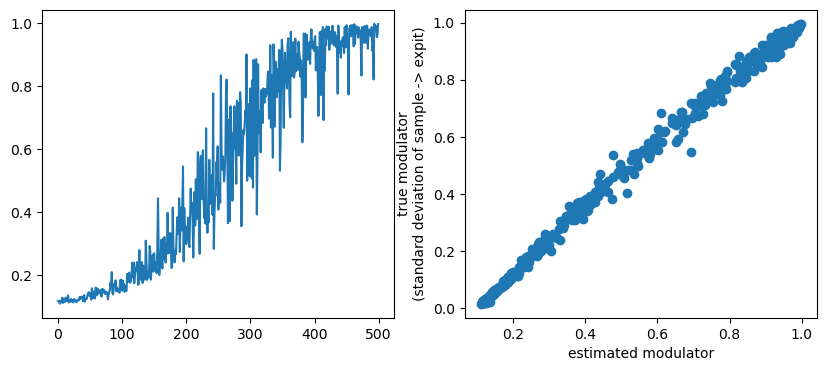

In [443]:
W_t = model.compute_adapt(Xa_t).cpu()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(W_t.numpy())
plt.subplot(1,2,2)
plt.scatter(W_t.numpy(), W)
plt.xlabel("estimated modulator")
plt.ylabel("true modulator\n(standard deviation of sample -> expit)")

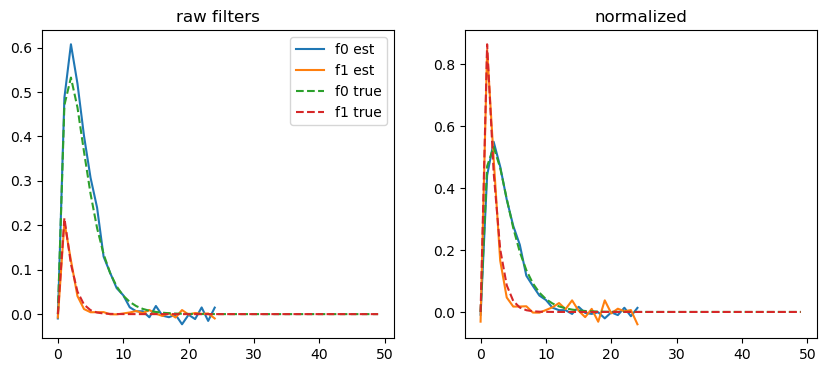

In [444]:

with torch.no_grad():
    filt_0_est = model.B_0.weight[0].cpu().numpy()
    filt_1_est = model.B_1.weight[0].cpu().numpy()
    Y_est = model(X_t,Xa_t).cpu().numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
cc = 1/Xs.std()
plt.plot(filt_0_est * cc, label="f0 est")
plt.plot(filt_1_est * cc,label="f1 est")
plt.plot(filter_0,'--',label="f0 true")
plt.plot(filter_1,'--',label="f1 true")
plt.title("raw filters")
plt.legend()

plt.subplot(1,2,2)
plt.plot(filt_0_est/np.linalg.norm(filt_0_est))
plt.plot(filt_1_est/np.linalg.norm(filt_1_est))
plt.plot(filter_0/np.linalg.norm(filter_0),'--')
plt.plot(filter_1/np.linalg.norm(filter_1),'--')
plt.title("normalized");

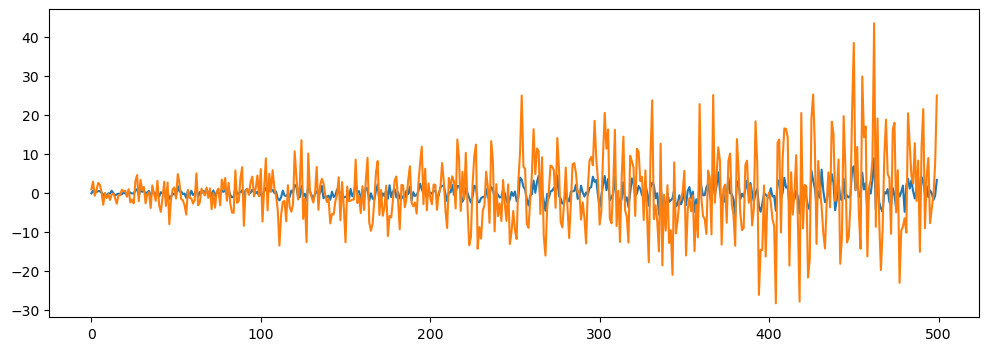

In [445]:
plt.figure(figsize=(12,4))
plt.plot(Xs @ filt_1_est)
plt.plot(Xs @ filt_0_est)

0.03989006896028265

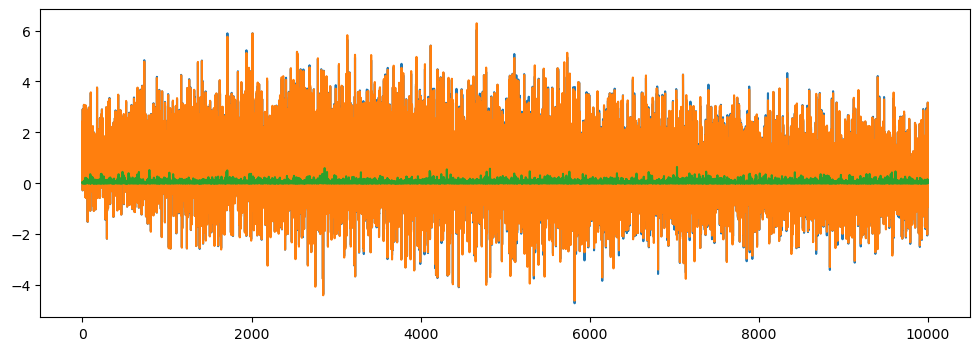

In [412]:
plt.figure(figsize=(12,4))
# plt.plot(Y)
plt.plot(Y_est)
plt.plot(X_filt.ravel())

plt.plot(((Y_est.ravel() - Y.ravel()) ** 2))
np.mean((Y_est.ravel() - Y.ravel()) ** 2)


In [ ]:
model = FixedAdaptiveLinear(P, 1)
X_t = torch.tensor(X,dtype=torch.float32)
W_t = torch.tensor(W,dtype=torch.float32)
Y_t = torch.tensor(Y,dtype=torch.float32).reshape(N,1)
criterion=torch.nn.MSELoss()
learning_rate=0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=2000)

In [ ]:
epochs=2000
model.train()
for epoch in range(epochs):
    epoch+=1
    
    #convert numpy array to torch Variable
    optimizer.zero_grad()
    
    #Forward to get outputs
    outputs=model(X_t,W_t)
    
    #calculate loss
    loss=criterion(outputs, Y_t)
    
    #getting gradients wrt parameters
    loss.backward()
    
    #updating parameters
    optimizer.step()
    scheduler.step()
    
    if(epoch % 50 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

In [ ]:
with torch.no_grad():
    filt_0_est = model.B_0.weight[0].numpy()
    filt_1_est = model.B_1.weight[0].numpy()
    Y_est = model(X_t,X_t).numpy()
plt.subplot(1,2,1)
plt.plot(filt_0_est)
plt.plot(filt_1_est)
plt.subplot(1,2,2)
plt.plot(Y)
plt.plot(Y_est);

In [474]:
a = torch.zeros([30,6,25])
b = torch.zeros(25,3)
torch.matmul(a,b).shape

torch.Size([30, 6, 3])

In [486]:
z = np.exp(np.random.randn(100000))

print(np.mean(z-np.exp(0.5)))
print(np.std((z-np.exp(0.5))/ np.sqrt(np.e*(np.e-1))))

0.0056331499323162065
1.0048747866148184
